# Reddit r/depression Data Preprocessing Pipeline

## Overview

This notebook processes raw Reddit submission and comment data from r/depression to create yearly interaction network snapshots for temporal network analysis.

### Input Data
- `depression_submissions` - Raw JSON data of all submissions to r/depression (~7GB)
- `depression_comments` - Raw JSON data of all comments in r/depression (~4.6GB)

### Output Data
- `yearly_graphs/edges_YYYY.csv` - Yearly edge lists (2009-2024) for network analysis
- `figures/network_evolution_overview.png` - Statistical overview visualization

### Processing Pipeline
1. Load and clean raw Reddit data using PySpark
2. Construct interaction edges from comments and submissions
3. Filter invalid data (deleted users, self-loops)
4. Export yearly snapshots as CSV files
5. Generate summary statistics and visualizations

### Note
This notebook handles only data preprocessing. For network analysis, see `dynamic_analysis.ipynb`.

---

## Section 1: Environment Setup

Configure the processing environment, import required libraries, and initialize Spark session.

### 1.1 Import Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import glob
from pathlib import Path

print("All libraries imported successfully")

All libraries imported successfully


### 1.2 Initialize Spark Session

Configure Spark with optimized memory settings for processing large datasets.

In [2]:
spark = SparkSession.builder \
    .appName("RedditDepressionPreprocessing") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .getOrCreate()

print(f"Spark session initialized")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/31 21:21:07 WARN Utils: Your hostname, cachyos, resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface wlan0)
25/12/31 21:21:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/31 21:21:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session initialized
Spark version: 4.0.1


### 1.3 Configure Visualization Settings

In [3]:
# Set plotting defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create output directories
Path('figures').mkdir(exist_ok=True)

print("Visualization settings configured")

Visualization settings configured


---

## Section 2: Data Loading and Exploration

Load raw JSON data and examine the schema to understand the data structure.

### 2.1 Load Raw Data

In [4]:
print("Loading raw data...")

submissions = spark.read.json("depression_submissions")
comments = spark.read.json("depression_comments")

print(f"Data loaded successfully")
print(f"Submissions: {submissions.count():,} records")
print(f"Comments: {comments.count():,} records")

Loading raw data...


25/12/31 21:21:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Data loaded successfully


Submissions: 1,797,948 records


Comments: 6,377,354 records


### 2.2 Preview Data Samples

In [5]:
print("\nSubmissions sample:")
submissions.show(5)

print("\nComments sample:")
comments.show(5)


Submissions sample:
+-----+-------------+-------------------+---------------+-----------+--------+-----------+--------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+-----------------+--------------------+--------------+--------+-------------+---------+----------+--------------+--------+------------+--------+-------+------------------+------------+-------+-----------+----------------+---------------------+---------------+-------------+---------------+-----+------+----+-------+---------+------+--------+------+----------+-----+----------------------+----------------+-------+-------------------+----------------------+------------------+-------+--------+-----+---------------------------+--------------------+-------------------+----------------------+---------------+---------------------+---------------+------+-----+--------------------+-

---

## Section 3: Data Cleaning and Transformation

Extract relevant fields and transform timestamps to prepare data for edge construction.

### 3.1 Clean Comments Dataset

**Objective:** Extract relevant fields and add temporal information.

**Transformations:**
- Select columns: `id`, `author`, `created_utc`, `parent_id`
- Convert Unix timestamp to year/month/day components
- Prepare for edge construction

**Understanding parent_id:**
- `t3_XXXXX` indicates a comment on a submission (post)
- `t1_XXXXX` indicates a reply to another comment

In [6]:
# Select relevant columns
comments = comments.select("id", "author", "created_utc", "parent_id")

# Convert timestamp to long and extract date components
comments = comments.withColumn("created_utc", 
                               F.col("created_utc").cast("double").cast("long"))

comments = comments.withColumn("year", 
                               F.year(F.from_unixtime("created_utc").cast("timestamp"))) \
                   .withColumn("month", 
                               F.month(F.from_unixtime("created_utc").cast("timestamp"))) \
                   .withColumn("day", 
                               F.dayofmonth(F.from_unixtime("created_utc").cast("timestamp")))

print("Comments cleaned and transformed")
print("\nSample of cleaned comments:")
comments.orderBy(F.col("created_utc").desc()).show(10)

Comments cleaned and transformed

Sample of cleaned comments:


+-------+-----------------+-----------+----------+----+-----+---+
|     id|           author|created_utc| parent_id|year|month|day|
+-------+-----------------+-----------+----------+----+-----+---+
|m4rvixo|      fmylife2024| 1735689484|t1_m4rv20i|2025|    1|  1|
|m4rv3xo|     Unreal_catto| 1735689327|t3_1hqevuc|2025|    1|  1|
|m4rv20i|Fabulous_Owl_8471| 1735689307|t1_m4ruqba|2025|    1|  1|
|m4rv1ox|        [deleted]| 1735689304|t3_1frqlk0|2025|    1|  1|
|m4ruqba|      fmylife2024| 1735689184|t1_m4rrqqh|2025|    1|  1|
|m4ru0xd|     Nutsyblazzer| 1735688918|t1_m4r70da|2025|    1|  1|
|m4rtwm7| Single_Berry7546| 1735688872|t1_m4rpwi1|2025|    1|  1|
|m4rtuzw|Fabulous_Owl_8471| 1735688855|t3_1hqnkkr|2025|    1|  1|
|m4rtm0a| Single_Berry7546| 1735688761|t1_m4rm736|2025|    1|  1|
|m4rthad|   tarteframboise| 1735688712|t3_1hqqtay|2025|    1|  1|
+-------+-----------------+-----------+----------+----+-----+---+
only showing top 10 rows


### 3.2 Clean Submissions Dataset

**Objective:** Extract submission authors for joining with comments.

We only need `id` and `author` to identify the submission author for comment-on-post edges.

In [7]:
# Keep only necessary columns
submissions = submissions.select("id", "author")

print("Submissions cleaned")
print("\nSample of cleaned submissions:")
submissions.show(5)

Submissions cleaned

Sample of cleaned submissions:
+-----+-----------+
|   id|     author|
+-----+-----------+
|7mqco|  [deleted]|
|7mqdw|HappyRabbit|
|7mqo7|  [deleted]|
|7mqur|  [deleted]|
|7mqyx|  [deleted]|
+-----+-----------+
only showing top 5 rows


---

## Section 4: Edge Construction

Build directed edges representing user interactions in the network.

### 4.1 Construct Comment-on-Post Edges

**Edge Definition:** Direct comment on a submission

**How to identify:**
- `parent_id` starts with `t3_` (Reddit's prefix for submissions)
- Extract submission ID and join with submissions table to find post author

**Edge representation:**
- Source: Comment author
- Target: Submission author
- Type: comment_on_post

In [8]:
comments_to_posts = comments.filter(F.col("parent_id").startswith("t3_")) \
    .withColumn("post_id", F.regexp_replace(F.col("parent_id"), "^t3_", "")) \
    .join(submissions, F.col("post_id") == submissions["id"], "inner") \
    .select(
        comments["author"].alias("source"),
        submissions["author"].alias("target"),
        comments["created_utc"].alias("timestamp"),
        F.lit("comment_on_post").alias("interaction_type"),
        comments["year"],
        comments["month"],
        comments["day"]
    )

print(f"Comment-on-post edges constructed: {comments_to_posts.count():,}")
print("\nSample edges:")
comments_to_posts.show(5)

Comment-on-post edges constructed: 3,631,843

Sample edges:


+-------------+-------------------+----------+----------------+----+-----+---+
|       source|             target| timestamp|interaction_type|year|month|day|
+-------------+-------------------+----------+----------------+----+-----+---+
| DedInside50s|         27Club2023|1672533471| comment_on_post|2023|    1|  1|
| youlackfacts|         27Club2023|1672534825| comment_on_post|2023|    1|  1|
|   Weary-Lime|Hatelovedemonslayer|1672543313| comment_on_post|2023|    1|  1|
|radish_recoup|Hatelovedemonslayer|1672579363| comment_on_post|2023|    1|  1|
|    irinirinn|         sad_apple5|1672565992| comment_on_post|2023|    1|  1|
+-------------+-------------------+----------+----------------+----+-----+---+
only showing top 5 rows


### 4.2 Construct Comment-on-Comment Edges

**Edge Definition:** Reply to another comment

**How to identify:**
- `parent_id` starts with `t1_` (Reddit's prefix for comments)
- Self-join comments table to find parent comment author

**Edge representation:**
- Source: Reply author
- Target: Parent comment author
- Type: comment_on_comment

In [9]:
comment_replies = comments.filter(F.col("parent_id").startswith("t1_")) \
    .withColumn("parent_comment_id", F.regexp_replace(F.col("parent_id"), "^t1_", "")) \
    .alias("c1") \
    .join(comments.alias("c2"), 
          F.col("c1.parent_comment_id") == F.col("c2.id"), "inner") \
    .select(
        F.col("c1.author").alias("source"),
        F.col("c2.author").alias("target"),
        F.col("c1.created_utc").alias("timestamp"),
        F.lit("comment_on_comment").alias("interaction_type"),
        F.col("c1.year"),
        F.col("c1.month"),
        F.col("c1.day")
    )

print(f"Comment-on-comment edges constructed: {comment_replies.count():,}")
print("\nSample edges:")
comment_replies.show(5)

Comment-on-comment edges constructed: 2,746,043

Sample edges:


+----------+--------------+----------+------------------+----+-----+---+
|    source|        target| timestamp|  interaction_type|year|month|day|
+----------+--------------+----------+------------------+----+-----+---+
| [deleted]|IheartDaRegion|1237915656|comment_on_comment|2009|    3| 24|
| [deleted]|      bluegerm|1254096044|comment_on_comment|2009|    9| 28|
|sickasabat|     [deleted]|1266596772|comment_on_comment|2010|    2| 19|
|    soitis|        mvoewf|1267353088|comment_on_comment|2010|    2| 28|
| [deleted]|        rymmen|1270956588|comment_on_comment|2010|    4| 11|
+----------+--------------+----------+------------------+----+-----+---+
only showing top 5 rows


### 4.3 Merge and Filter Edges

**Filtering criteria:**
1. Remove `[deleted]` users (both source and target)
2. Remove self-loops (source != target)
3. Keep only years < 2025 (data collection cutoff)

**Result:** Clean edge list representing genuine user interactions.

In [10]:
# Merge both edge types
edges = comments_to_posts.union(comment_replies)

# Apply filters
edges = edges.filter(
    (F.col("source") != "[deleted]") & 
    (F.col("target") != "[deleted]") & 
    (F.col("source") != F.col("target")) & 
    (F.col("year") < 2025)
).orderBy("timestamp")

# Cache for reuse
edges.cache()

total_edges = edges.count()
print(f"Edges merged and filtered: {total_edges:,} interactions")
print("\nSample final edges:")
edges.show(10)

Edges merged and filtered: 4,116,812 interactions

Sample final edges:
+-------------+----------+----------+------------------+----+-----+---+
|       source|    target| timestamp|  interaction_type|year|month|day|
+-------------+----------+----------+------------------+----+-----+---+
|  redmosquito|    cluuxz|1230789682|comment_on_comment|2009|    1|  1|
|   Ostrich159|    cluuxz|1230796786|comment_on_comment|2009|    1|  1|
|     cujo3017|    cluuxz|1230800681|comment_on_comment|2009|    1|  1|
|bobkingof12vs|OctopusMan|1230805754|comment_on_comment|2009|    1|  1|
|bobkingof12vs|  i_love_u|1230807596|   comment_on_post|2009|    1|  1|
|     g2petter|OctopusMan|1230812559|comment_on_comment|2009|    1|  1|
|   julenissen|OctopusMan|1230816912|comment_on_comment|2009|    1|  1|
|      lemming|OctopusMan|1230833115|comment_on_comment|2009|    1|  1|
|         mmmf|    cluuxz|1230845741|comment_on_comment|2009|    1|  1|
|ThatOtherGirl|OctopusMan|1231130231|comment_on_comment|2009|    

---

## Section 5: Data Quality Assessment

Quantify data quality and understand filtering impact.

### 5.1 Deletion Statistics

In [11]:
# Calculate total before filtering
cmt_on_cmt_count = comment_replies.count()
cmt_on_pst_count = comments_to_posts.count()
total_before_filter = cmt_on_cmt_count + cmt_on_pst_count

# Calculate deleted
deleted = total_before_filter - total_edges
deleted_pct = (deleted / total_before_filter) * 100

print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)
print(f"\nTotal interactions (before filtering): {total_before_filter:,}")
print(f"Valid interactions (after filtering):   {total_edges:,}")
print(f"Deleted interactions:                   {deleted:,} ({deleted_pct:.2f}%)")
print(f"\nInteraction types:")
print(f"  Comment-on-post:     {cmt_on_pst_count:,}")
print(f"  Comment-on-comment:  {cmt_on_cmt_count:,}")
print("="*80)

DATA QUALITY ASSESSMENT

Total interactions (before filtering): 6,377,886
Valid interactions (after filtering):   4,116,812
Deleted interactions:                   2,261,074 (35.45%)

Interaction types:
  Comment-on-post:     3,631,843
  Comment-on-comment:  2,746,043


### 5.2 Compute Yearly Statistics

In [12]:
# Compute statistics per year
yearly_stats = edges.groupBy('year').agg(
    F.count('*').alias('num_edges'),
    F.countDistinct('source').alias('num_sources'),
    F.countDistinct('target').alias('num_targets'),
    F.countDistinct(F.concat('source', 'target')).alias('unique_pairs')
).orderBy('year')

# Compute unique users per year (union of sources and targets)
sources = edges.select('year', F.col('source').alias('user'))
targets = edges.select('year', F.col('target').alias('user'))

unique_users_per_year = sources.union(targets) \
    .groupBy('year') \
    .agg(F.countDistinct('user').alias('num_unique_users')) \
    .orderBy('year')

# Join statistics
yearly_stats = yearly_stats.join(unique_users_per_year, on='year', how='left')

print("Yearly Statistics:")
yearly_stats.show(truncate=False)

Yearly Statistics:


+----+---------+-----------+-----------+------------+----------------+
|year|num_edges|num_sources|num_targets|unique_pairs|num_unique_users|
+----+---------+-----------+-----------+------------+----------------+
|2018|501110   |96115      |81217      |396571      |113274          |
|2015|258452   |52956      |47995      |205018      |64216           |
|2023|245701   |68041      |54239      |206253      |83232           |
|2022|245621   |71411      |60263      |201117      |88218           |
|2013|132251   |31438      |27466      |102740      |38167           |
|2014|159839   |38317      |34686      |124411      |46941           |
|2019|568433   |119209     |98910      |449891      |140128          |
|2020|429705   |104513     |87521      |335407      |124622          |
|2012|91852    |19695      |16982      |71668       |23557           |
|2009|721      |213        |173        |549         |255             |
|2016|340632   |63587      |55676      |275469      |76105           |
|2024|

---

## Section 6: Summary Visualization

Create comprehensive visualizations showing network evolution over time.

### 6.1 Prepare Data for Visualization

In [13]:
# Convert to Pandas
df_yearly = yearly_stats.toPandas()
df_yearly = df_yearly.sort_values("year").reset_index(drop=True)

# Calculate derived metrics
df_yearly['avg_degree'] = (2 * df_yearly['num_edges']) / df_yearly['num_unique_users']
df_yearly['density'] = df_yearly['num_edges'] / (df_yearly['num_unique_users'] * (df_yearly['num_unique_users'] - 1))
df_yearly['density_pct'] = df_yearly['density'] * 100

# Display complete statistics
print("\n" + "="*80)
print("COMPLETE YEARLY STATISTICS")
print("="*80)
print(df_yearly.to_string(index=False))
print("="*80)


COMPLETE YEARLY STATISTICS
 year  num_edges  num_sources  num_targets  unique_pairs  num_unique_users  avg_degree  density  density_pct
 2009        721          213          173           549               255    5.654902 0.011132     1.113170
 2010       8525         2145         1798          6721              2551    6.683653 0.001311     0.131052
 2011      27164         6895         5914         21977              8342    6.512587 0.000390     0.039040
 2012      91852        19695        16982         71668             23557    7.798277 0.000166     0.016553
 2013     132251        31438        27466        102740             38167    6.930123 0.000091     0.009079
 2014     159839        38317        34686        124411             46941    6.810209 0.000073     0.007254
 2015     258452        52956        47995        205018             64216    8.049458 0.000063     0.006268
 2016     340632        63587        55676        275469             76105    8.951633 0.000059     

### 6.2 Create Network Evolution Dashboard

Four-panel visualization showing:
1. Network size growth (nodes and edges)
2. Density evolution
3. Average degree over time
4. Year-over-year growth rates

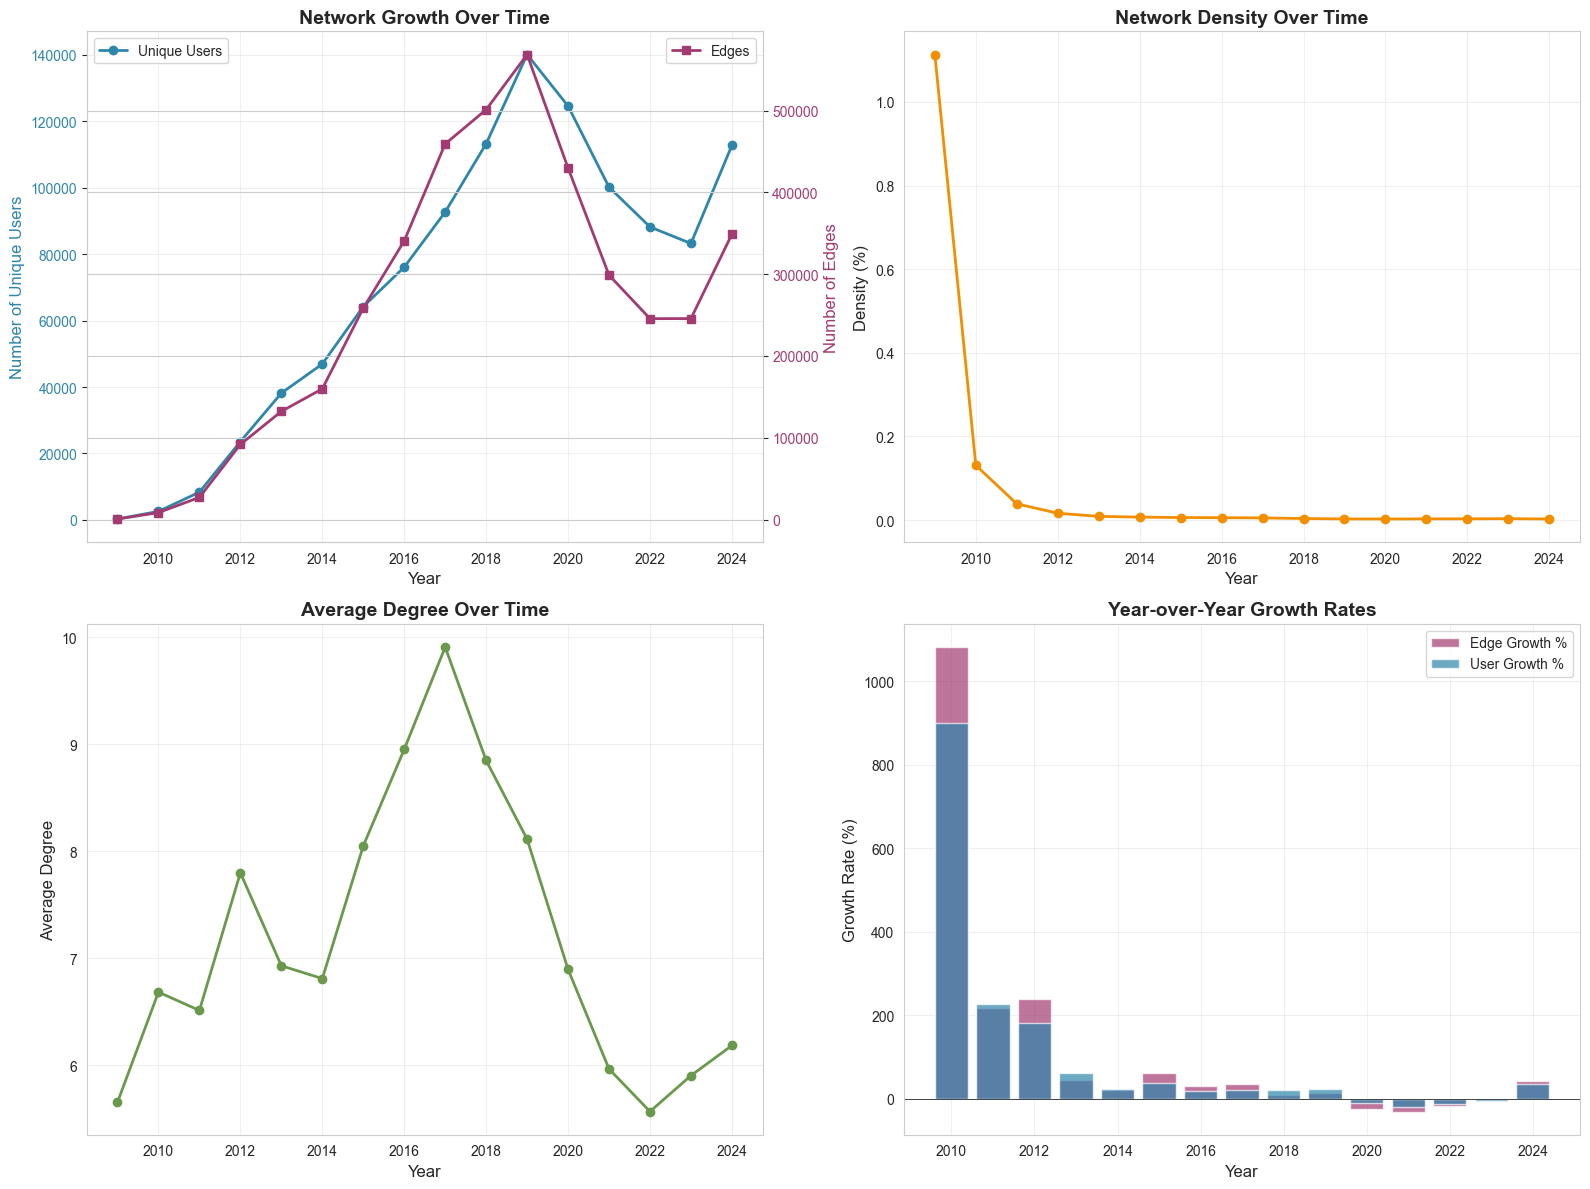


Visualization saved: figures/network_evolution_overview.png


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Network Growth
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

ax1.plot(df_yearly['year'], df_yearly['num_unique_users'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Unique Users')
ax1_twin.plot(df_yearly['year'], df_yearly['num_edges'], 
              marker='s', linewidth=2, markersize=6, color='#A23B72', label='Edges')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Unique Users', fontsize=12, color='#2E86AB')
ax1_twin.set_ylabel('Number of Edges', fontsize=12, color='#A23B72')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1_twin.tick_params(axis='y', labelcolor='#A23B72')
ax1.set_title('Network Growth Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Density Evolution
ax2 = axes[0, 1]
ax2.plot(df_yearly['year'], df_yearly['density_pct'], 
         marker='o', linewidth=2, markersize=6, color='#F18F01')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Density (%)', fontsize=12)
ax2.set_title('Network Density Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Average Degree
ax3 = axes[1, 0]
ax3.plot(df_yearly['year'], df_yearly['avg_degree'], 
         marker='o', linewidth=2, markersize=6, color='#6A994E')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Average Degree', fontsize=12)
ax3.set_title('Average Degree Over Time', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Growth Rates
ax4 = axes[1, 1]
df_yearly['edge_growth_pct'] = df_yearly['num_edges'].pct_change() * 100
df_yearly['user_growth_pct'] = df_yearly['num_unique_users'].pct_change() * 100

ax4.bar(df_yearly['year'][1:], df_yearly['edge_growth_pct'][1:], 
        alpha=0.7, label='Edge Growth %', color='#A23B72')
ax4.bar(df_yearly['year'][1:], df_yearly['user_growth_pct'][1:], 
        alpha=0.7, label='User Growth %', color="#2E86AB")
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Growth Rate (%)', fontsize=12)
ax4.set_title('Year-over-Year Growth Rates', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/network_evolution_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: figures/network_evolution_overview.png")

---

## Section 7: Export Yearly Snapshots

Export edge lists by year as CSV files for downstream network analysis.

### 7.1 Create Output Directory

In [15]:
output_dir = 'yearly_graphs'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory created: {output_dir}/")

Output directory created: yearly_graphs/


### 7.2 Export Edge Lists by Year

Each year is exported as a separate CSV file:
- `yearly_graphs/edges_2009.csv`
- `yearly_graphs/edges_2010.csv`
- ...
- `yearly_graphs/edges_2024.csv`

**Columns in each file:**
- `source`: Comment author (edge source)
- `target`: Recipient (post author or parent comment author)
- `timestamp`: Unix timestamp
- `interaction_type`: 'comment_on_post' or 'comment_on_comment'

In [16]:
years_to_export = range(2009, 2025)

print("Starting export of yearly edge lists...")
print("="*80)

for year in years_to_export:
    # Filter edges for this year
    year_edges = edges.filter(F.col('year') == year)
    
    # Count edges
    edge_count = year_edges.count()
    
    # Export to CSV
    year_edges.select('source', 'target', 'timestamp', 'interaction_type') \
        .coalesce(1) \
        .write.mode('overwrite') \
        .option('header', 'true') \
        .csv(f'{output_dir}/temp_{year}')
    
    print(f"  Year {year}: {edge_count:,} edges exported")

print("="*80)
print("All years exported successfully")

Starting export of yearly edge lists...
  Year 2009: 721 edges exported
  Year 2010: 8,525 edges exported
  Year 2011: 27,164 edges exported
  Year 2012: 91,852 edges exported
  Year 2013: 132,251 edges exported
  Year 2014: 159,839 edges exported
  Year 2015: 258,452 edges exported
  Year 2016: 340,632 edges exported


  Year 2017: 459,203 edges exported


  Year 2018: 501,110 edges exported


  Year 2019: 568,433 edges exported
  Year 2020: 429,705 edges exported
  Year 2021: 298,801 edges exported
  Year 2022: 245,621 edges exported
  Year 2023: 245,701 edges exported
  Year 2024: 348,802 edges exported
All years exported successfully


### 7.3 Clean Up File Structure

Spark creates temporary directories with part files. This step renames them to clean filenames.

In [17]:
print("Cleaning up file structure...")

for year in years_to_export:
    temp_dir = f'{output_dir}/temp_{year}'
    
    # Find CSV file created by Spark
    csv_files = glob.glob(f'{temp_dir}/part-*.csv')
    
    if csv_files:
        # Rename to clean filename
        final_filename = f'{output_dir}/edges_{year}.csv'
        shutil.move(csv_files[0], final_filename)
        
        # Remove temp directory
        shutil.rmtree(temp_dir)
        
print("File structure cleaned")
print(f"\nOutput files: {output_dir}/edges_YYYY.csv (2009-2024)")

Cleaning up file structure...
File structure cleaned

Output files: yearly_graphs/edges_YYYY.csv (2009-2024)


---

## Section 8: Processing Summary

In [18]:
print("\n" + "="*80)
print("PREPROCESSING COMPLETE")
print("="*80)

print(f"\nData Summary:")
print(f"  Total interactions processed: {total_edges:,}")
print(f"  Years covered: 2009-2024 ({len(list(years_to_export))} years)")
print(f"  Total unique users (across all years): {df_yearly['num_unique_users'].sum():,}")

print(f"\nOutput Files Generated:")
print(f"  Edge lists: yearly_graphs/edges_YYYY.csv (16 files)")
print(f"  Visualization: figures/network_evolution_overview.png")

print(f"\nKey Statistics:")
print(f"  Peak year (users): {df_yearly.loc[df_yearly['num_unique_users'].idxmax(), 'year']:.0f} ({df_yearly['num_unique_users'].max():,} users)")
print(f"  Peak year (edges): {df_yearly.loc[df_yearly['num_edges'].idxmax(), 'year']:.0f} ({df_yearly['num_edges'].max():,} edges)")
print(f"  Data retention rate: {(1 - deleted_pct/100)*100:.1f}%")

print(f"\nNext Steps:")
print(f"  Use dynamic_analysis.ipynb for temporal network analysis")
print(f"  Edge files are ready for parallel processing")

print("="*80)


PREPROCESSING COMPLETE

Data Summary:
  Total interactions processed: 4,116,812
  Years covered: 2009-2024 (16 years)
  Total unique users (across all years): 1,115,275

Output Files Generated:
  Edge lists: yearly_graphs/edges_YYYY.csv (16 files)
  Visualization: figures/network_evolution_overview.png

Key Statistics:
  Peak year (users): 2019 (140,128 users)
  Peak year (edges): 2019 (568,433 edges)
  Data retention rate: 64.5%

Next Steps:
  Use dynamic_analysis.ipynb for temporal network analysis
  Edge files are ready for parallel processing


---

## Section 9: Cleanup (Optional)

Stop the Spark session to free system resources.

In [20]:
spark.stop()
print("Spark session stopped")

Spark session stopped
